In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from layers import FreeSpacePropagation
import time
import pandas as pd
import cv2
from cxlayers import AngularSpectrum, ImageResizing, ImageToElectricField, ImageBinarization, CxMO, CxD2NNFaradayRotation, CxD2NNIntensity, D2NNMNISTDetector, Polarizer, GGG, Softmax


plt.rcParams["font.size"]=18

In [156]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

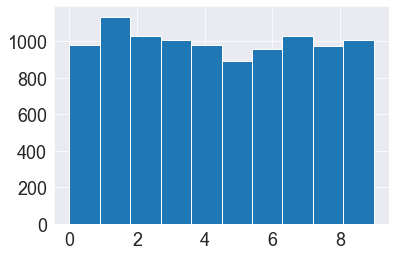

In [157]:
plt.hist(y_test)

In [164]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

2022-04-15 12:49:45.942790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


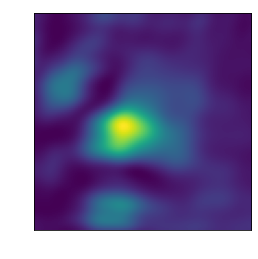

In [190]:
shape = (100, 100)
inputs = tf.keras.Input((28, 28))
x = ImageResizing(shape)(inputs)
x = ImageBinarization(0.5, 0.0, 1.0)(x)
x = ImageToElectricField(shape)(x)
x = CxMO(shape, limitation='sin', limitation_num=np.pi/6)(x)
x = AngularSpectrum(shape, wavelength=531e-9, z=0.5e-3, d=1.0e-6, normalization='max', method='expand')(x)
# x = CxD2NNFaradayRotation(shape, avoid_zero=True)(x)
# x = Polarizer(shape)(x)
# x = CxD2NNIntensity(shape)(x)
x = Argument(shape)(x)
x = D2NNMNISTDetector(10)(x)
x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, x)

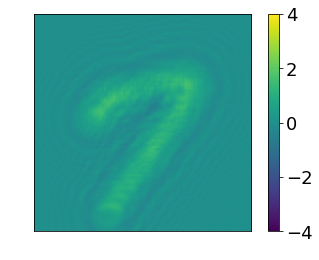

In [85]:
weights = model.layers[4].get_weights()
phase = np.loadtxt("data/phase/100px/train_7.csv") * 2.1 * np.pi/180
tx = np.linspace(-np.pi, np.pi, 100)
ty = np.linspace(-np.pi, np.pi, 100)
XX, YY = np.meshgrid(tx, ty)
W = np.sqrt(XX**2 + YY**2)
weights[0] = phase
model.layers[4].set_weights(weights)
image = np.ones((2, 28, 28))
pred = model.predict(image)
plt.imshow(pred[0,:,:] * 180 / np.pi)
plt.colorbar()
plt.clim(-4, 4)
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)

In [68]:
model = tf.keras.models.load_model("test")
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_22 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_22 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 image_to_electric_field_22   (None, 2, 2, 100, 100)   0         
 (ImageToElectricField)                                          
                                                                 
 cx_mo_12 (CxMO)             (None, 2, 2, 100, 100)    10002     
                                                          

(0,)


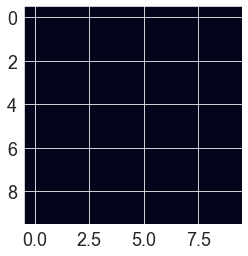

In [155]:
def check_zero_range(x, eps):
    return -eps < x < eps

e = np.arange(-5, 5, 1.0)
x = 10.0**e
XX, YY = np.meshgrid(x, x)

a = tf.constant(XX, dtype=tf.float16)
b = tf.constant(YY, dtype=tf.float16)
arg = 2.0 * tf.atan((tf.sqrt(a**2 + b**2) - a)/b)

print(arg[np.isnan((arg.numpy()))].shape)
plt.imshow(np.isnan(arg.numpy()))
